### 1. FFMPEG
> * We create images from short video clips.

In [1]:
import os
from subprocess import check_call
import sys
import shutil
from tqdm import tqdm

In [2]:
def rename_files_in(dir_name, ending='.mov'):
    """
    Renames all files in the given dir
    to integers, i.e xxx.mov -> 1.mov, ... N.mov
    """
    assert os.path.isdir(dir_name)
    all_filenames = os.listdir(dir_name)
    all_filenames = [f for f in all_filenames if f.endswith(ending)]
    N = len(all_filenames)
    for i in tqdm(xrange(N)):
        cur_name = os.path.join(dir_name, all_filenames[i])
        new_name = os.path.join(dir_name, str(i)+ending)
        os.rename(cur_name, new_name)

In [3]:
def ffmpeg_videos_to_files(dir_name):
    """
    Splits all .mov files in the specified
    directory into all of its frames. The resulting
    jpegs for each file are dropped in a newly created
    directory. 
        234.mov -> 234/[a.jpg, b.jpg, ..., last.jpg]
    The clips are not deleted afterward.
    """
    assert os.path.isdir(dir_name)
    clips = os.listdir(dir_name)
    clips = [c for c in clips if c.endswith('.mov')]
    clips = sorted(clips, key=lambda name : int(name[:-4]))
    for i in xrange(len(clips)):
        cur_clip = os.path.join(dir_name, clips[i])
        new_dir_name = os.path.join(dir_name, str(i))
        if not os.path.exists(new_dir_name):
            os.mkdir(new_dir_name)
        cmd = "ffmpeg -i {video} -vf fps=5 {result_name} -hide_banner".format(
            video=cur_clip,
            result_name=os.path.join(new_dir_name, str(i)+"_%02d.jpg")
        )
        print(cmd)
        check_call(cmd, shell=True)

In [4]:
# ffmpeg_videos_to_files('./Clips/')

In [5]:
def num_images(dir_name):
    folders = [f for f in os.listdir(dir_name) if f not in ['src_clips', '.DS_Store']]
    total = 0
    for f in folders:
        try:
            contents = os.listdir(os.path.join(dir_name, f))
            k = len(contents) 
#             if "annotations" not in contents:
#                 shutil.move(os.path.join(dir_name, f), os.path.join("./Rejected/", f))
        except:
            k = 0
        total += k
    print total

In [6]:
# num_images('./Images/')

In [7]:
def canonicalize_files(start_dir, end_dir, parent_dir):
    """
    Turn the files in a named directory (a directory named using rename_files_in)
    into a standardized format DIRNUM_FILNUM
    """
    for i in xrange(start_dir, end_dir+1):
        current_dir = os.path.join(parent_dir, str(i))
        if not os.path.isdir(current_dir): continue
        files = os.listdir(current_dir)
        for j, _, in enumerate(files):
            cur_name = os.path.join(current_dir, files[j])
            if j > 9:
                new_name = os.path.join(current_dir, str(i)+"_"+str(j)+".jpg")
            else:
                new_name = os.path.join(current_dir, str(i)+"_0"+str(j)+".jpg")
            os.rename(cur_name, new_name)

In [8]:
# canonicalize_files(495, 496, "./Images/")

### 2. Scraping
> * Below this point lies code for scraping specific images from Amazon.
> * Parts of the code in this section are ported from [here](https://github.com/hartleybrody/public-amazon-crawler)

In [9]:
# from collections import deque
# from bs4 import BeautifulSoup as bs
# class AmazonImageScraper:
#     def __init__(self, init_file):
#         self.products_deque = self._init_deque(init_file)
#         self.scraper_pool = self._init_thread_pool()
        
    
#     def _init_deque(self, init_file):
#         pass
        
#     def _init_thread_pool(self):
#         pass
    
#     def scrap(self):
#         pass
    
#     def fetch_page(self, link):
#         pass
    
#     def retrieve_nutri_images(self, page):
#         pass
    
#     def retrieve_other_product_links(self, page):
#         pass

### 3. Data Pre-Processing
> * The code beyond this point does data cleaning and the usual data stuff.
> * Aggregate Images into a single directory. Additionally, collate bbox data into a single .npy file

In [10]:
'''
Process bounding box data.

We aggregate raw bboxes into  ....
'''
import xml.etree.ElementTree as ET 
from bs4 import BeautifulSoup as bs
import numpy as np

In [11]:
def extract_contents(annotations_folder):
        all_annotations = os.listdir(annotations_folder)
        return [os.path.join(annotations_folder, item) for item in all_annotations]
        
def get_all_raw_xml_annotations(parent_dir):
    """
    Walks through parent dir looking for folders named `annotations`
    and aggregates paths to their contents into a list.
    """
    annotation_list = []
    top_level_contents = os.listdir(parent_dir)
    for item_name in top_level_contents:
        if item_name.startswith('.'): continue
        if item_name == 'deleted': continue
        if item_name.endswith('.jpg'): 
#             print item_name
            shutil.move(os.path.join(parent_dir, item_name), os.path.join('../IM', item_name))
            continue
        if item_name == 'annotations':
            annotation_list += extract_contents(os.path.join(parent_dir, item_name))
            continue
        
        cur_dir = os.path.join(parent_dir, item_name)
        inner_level_contents = os.listdir(cur_dir)
        for item in inner_level_contents:
            if item_name.startswith('.'): continue
            if item_name == 'deleted': continue
            if item.endswith('.jpg'):
                shutil.move(os.path.join(cur_dir, item), os.path.join('../IM', item))
                continue
            if item == 'annotations':
                annotation_list +=  extract_contents(os.path.join(cur_dir, item))
    return annotation_list

In [12]:
# annotation_paths = get_all_raw_xml_annotations('../Images copy/')

In [13]:
def ensure_correct_labels(img_name, o1, o2):
    if o1['name'] == None or o1['name'].strip() == "":
        if o2['name'].strip() == 'nutrition': o1['name'] = "ingridients"
        elif o2['name'].strip() == 'ingridients': o1['name'] = "nutrition"
        else: print "Critical Error: Both Blank at, ", img_name
        
    elif o2['name'] == None or o2['name'].strip() == "":
        if o1['name'].strip() == 'nutrition': o2['name'] = "ingridients"
        elif o1['name'].strip() == 'ingridients': o2['name'] = 'nutrition'
        else: print "Critical Error: Both Blank at, ", img_name
    
    
def create_annotations_dict(paths_to_annotations):
    """
        consumes the xml paths, parses the dest xml and spits out
        a python dict of the form
            {
                '305_61.jpg' -> (
                    (x1, y1, x2, y2, x2, y3, x4, y4), -- nutrition_bbox
                    (x1, y1, x2, y2, x2, y3, x4, y4), -- ingredient_bbox
                    (orig_width, orig_height) -- orig_size
                )
            }
    """
    annotations_dict = {}
    for xml_path in paths_to_annotations:
        img_file_name = xml_path[xml_path.rfind('/')+1:].replace('xml', 'jpg')  
        tree = ET.ElementTree(file=xml_path)
        
        orig_width, orig_height = None, None
        object_1, object_2 = None, None
        for elem in tree.iter():
            if elem.tag == 'width': orig_width = elem.text
            if elem.tag =='height': orig_height = elem.text
            if elem.tag =='object':
                try:
                    if object_1 is None: 
                        object_1 = [(e.tag.strip(),e.text.strip()) for e in list(elem.iter())]
                    else:
                        object_2 = [(e.tag.strip(), e.text.strip()) for e in list(elem.iter())]
                except:
                    if object_1 is None: 
                        object_1 = [(e.tag.strip(),e.text) for e in list(elem.iter())]
                    else:
                        object_2 = [(e.tag.strip(), e.text) for e in list(elem.iter())]
                    
        if object_1 is None or object_2 is None:
            """Worry not about these."""
            continue
        if (orig_width, orig_height) != ('1080', '1920'):
            """Ignore Images of not this size. We shall revisit this"""
            continue
        items_of_interest = {'name', 'x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3', 'y4'}
        object_1 = {i[0]:i[1] for i in object_1 if i[0] in items_of_interest}
        object_2 = {i[0]:i[1] for i in object_2 if i[0] in items_of_interest}
        
        ensure_correct_labels(img_file_name, object_1, object_2)
        
        ingr = object_1 if object_1['name'] =='ingridients' else object_2
        nutr = object_1 if object_1['name'] =='nutrition' else object_2
        try:
            ingredient_locs = (
                ingr['x1'], ingr['y1'], 
                ingr['x2'], ingr['y2'], 
                ingr['x3'], ingr['y3'], 
                ingr['x4'], ingr['y4']
            )
            nutrition_locs = (
                nutr['x1'], nutr['y1'],
                nutr['x2'], nutr['y2'],
                nutr['x3'], nutr['y3'],
                nutr['x4'], nutr['y4'],
            )
        except:
            print "Critical error with", img_file_name, " triangle"
            continue
        orig_size = (orig_width, orig_height)
        value = (nutrition_locs, ingredient_locs, orig_size)
        annotations_dict[img_file_name] = value
    print(len(annotations_dict))
    np.save("labels_dict.npy", annotations_dict)

In [14]:
# create_annotations_dict(annotation_paths)

### 4. Visualizing the data: Localization.
> * Now that we have our training data, let's visualize some images to be used in the localization step.

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.display import display, HTML
from collections import  Counter
from itertools import chain
sns.set_style("whitegrid", {'axes.grid' : False})
%matplotlib inline
from tqdm import tqdm
from random import shuffle

In [225]:
labels = np.load("./FullData/BoundingBoxes.npy").item()
IMAGE_DIR = "./FullData/RawImages/"
images = os.listdir(IMAGE_DIR)

21_15.jpg


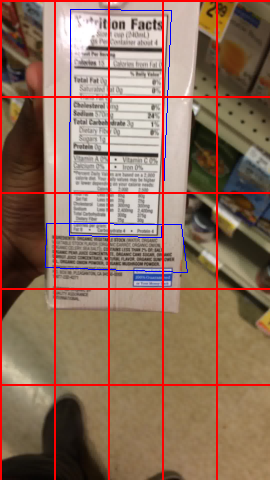

In [293]:
def display_grid_cells(image, draw, shrink_factor_w, shrink_factor_h, S=5):
    w, h = image.size
    cell_w = w//S
    cell_h = h//S
    start_ws = [i*cell_w for i in range(S)]
    start_hs = [i*cell_h for i in range(S)]
    
    for i in start_ws:
        draw.line([(i, 0), (i, h)], width=2, fill='red')
    for i in start_hs:
        draw.line([(0, i), (w, i)], width=2, fill='red')
    return image

def get_bbox_center(coords):
    x = sum([t[0] for t in coords])//4
    y = sum([t[1] for t in coords])//4
    return (x, y)

def center_in_cell(center, cell_start, cell_w, cell_h):
    cell_start_x = cell_start[0]; cell_end_x = cell_start_x + cell_w
    cell_start_y = cell_start[1]; cell_end_y = cell_start_y + cell_h
    if (center[0] < cell_start_x) or (center[0] > cell_end_x):
        return False
    if (center[1] < cell_start_y) or (center[1] > cell_end_y):
        return False
    return True

def create_target_tensor(nutrition, ingridients, w, h, S=5):
    cell_w = w//S ;cell_h = h//S
    ingr_center = get_bbox_center(ingridients)
    nutr_center = get_bbox_center(nutrition)
    ingridients = [(t[0]/float(w), t[1]/float(h)) for t in ingridients]
    nutrition = [(t[0]/float(w), t[1]/float(h)) for t in nutrition]
    target_tensor = np.zeros((S, S, 2, 11), dtype=np.float32)
    ingr_t = np.array(
        list(chain.from_iterable(ingridients))
    )
    nutr_t = np.array(
        list(chain.from_iterable(nutrition))
    )
    for i in range(S):
        for j in range(S):
            start = (i*cell_w, j*cell_h)
            nutr_in_cell = center_in_cell(nutr_center, start, cell_w, cell_h)
            ingr_in_cell = center_in_cell(ingr_center, start, cell_w, cell_h)
            if nutr_in_cell:
                target_tensor[i, j, 0, 0] = 1
                target_tensor[i, j, 0, 1:-2] = nutr_t
                target_tensor[i, j, 0, -2] = 1
            if ingr_in_cell:
                target_tensor[i, j, 1, 0] = 1
                target_tensor[i, j, 1, 1:-2] = ingr_t
                target_tensor[i, j, 1, -1] = 1
    return target_tensor
            
def display_bounding_boxes(image, bounding_boxes):
    """
    Displays an image and overlays the bounding boxes
    """
    draw = ImageDraw.Draw(image)
    for coords in bounding_boxes:
        draw.polygon(coords, outline="blue")
    image = display_grid_cells(image, draw, 4, 4)
    return image

def rotate_bounding_boxes_90(coords, width, height):
    """
    A point (a, b) rotated around the origin 270 (90 counter) degrees will 
    transform to point (b - y + x, -(a - x) + y).
    """
    new_coords = []
    diff = abs(int(width) - int(height))/2
    x, y = int(width)/2, int(height)/2
    for l in coords:
        new_l = [0]*len(l)
        for i in xrange(0, len(l), 2):
            a, b = int(l[i]), int(l[i+1])
            new_x = max((b-y)+x - diff, 0)
            new_y =  max(-(a-x)+y + diff, 0)
            new_l[i] = new_x; new_l[i+1] = new_y
        new_coords.append(tuple(new_l))
    return tuple(new_coords)
    
def linearly_scale_bounding_boxes(nutrition, ingridients, shrink_factor_w, shrink_factor_h):
    nutrition_coords = [(
            int(nutrition[i])/shrink_factor_w, int(nutrition[i+1])/shrink_factor_h
        ) for i in xrange(0, len(nutrition), 2)]
    ingridients_coords = [(
            int(ingridients[i])/shrink_factor_w, int(ingridients[i+1])/shrink_factor_h
        ) for i in xrange(0, len(ingridients), 2)]
    return (nutrition_coords, ingridients_coords)
    
def gen_bbox_coords(image_name, shrink_factor):
    '''
    retuns list of coords for display_bounding_boxes
    to consume.
    '''
    orig_w, orig_h = labels[image_name][-1]
    nutrition, ingridients = labels[image_name][:-1]
    
    image = Image.open(os.path.join(IMAGE_DIR, image_name)).resize(
        (int(orig_w)/shrink_factor, int(orig_h)/shrink_factor),
        resample = Image.BILINEAR
    ).convert('RGBA')
    nutrition_coords, ingridients_coords = linearly_scale_bounding_boxes(
        nutrition, ingridients, shrink_factor, shrink_factor
    )
    create_target_tensor(
        nutrition_coords, ingridients_coords, 
        int(orig_w)/shrink_factor, int(orig_h)/shrink_factor
    )
    return image, [nutrition_coords, ingridients_coords]
    
image_name = "21_15.jpg" #images[21]
print(image_name)
image, coords = gen_bbox_coords(image_name, 4)
# print image.size
display_bounding_boxes(image, coords)

In [18]:
non_canonical_path = "../Data/NonCanonicalImages/"
new_labels = {}
def resize_images_on_disk():
    '''
    resize images not of the canonical size into the canonical size
    and adjust their bounding boxes accordingly
    tqdm(mydict.iteritems(), total=len(mydict)
    '''
    for k in tqdm(labels.keys()):
        v = labels[k]
        target_shape = ('1080', '1920')
        if v[-1] == target_shape: 
            new_labels[k] = v
            continue
        if v[-1] == ('2448', '3264') or v[-1] == ('500', '500') or v[-1] == ('3264', '2448'):
            try:
                shutil.move(
                    os.path.join(IMAGE_DIR, k), 
                    os.path.join(non_canonical_path, k)
                )
            except:
                continue
        elif v[-1] == ('1920', '1080'):
            image = Image.open(os.path.join(IMAGE_DIR, k))
            bbox_coords = rotate_bounding_boxes_90(
                v[:-1], v[-1][0], v[-1][1]
            )
            image = image.rotate(90, expand=True)
            bbox_coords = bbox_coords + (target_shape,)
            new_labels[k] = bbox_coords
            image.save(os.path.join(IMAGE_DIR, k))
# resize_images_on_disk()

In [219]:
def split_data():
    '''
    Partition data 95, 2.5, 2.5 at the clip level
    not the image level.
    '''
    all_images = os.listdir(IMAGE_DIR)
    all_clips = list(
        set([int(cur_img[:cur_img.rfind('_')]) for cur_img in all_images])
    )
    shuffle(all_clips)
    N = len(all_clips)
    
    train, dev, test = int(0.95*N)+2, int(0.025*N), int(0.025*N)
    T, D, TE = all_clips[:train], all_clips[train:train+dev], all_clips[-test:]
    train, dev, test = [], [], []
    for f in all_images:
        id_ = int(f[:f.rfind('_')])
        if id_ in T: train.append(f)
        elif id_ in D: dev.append(f)
        else: test.append(f)     
    shuffle(train); shuffle(dev); shuffle(test)
    files = {
        "train" : train,
        "dev": dev,
        "test": test,
    }
    np.save("./FullData/train_dev_test.npy", files)

In [19]:
# def remove_all_non_canonical():
#     train_files = os.listdir(IMAGE_DIR)
#     canonical_files = np.load("./labels_dict.npy").item().keys()
#     for f in train_files:
#         if f not in canonical_files:
#             os.remove(os.path.join(IMAGE_DIR, f))
# remove_all_non_canonical()

### 5. Visualize the Data: Transcription
> * Visualize some of the data to be used in the non E2E transcription task.
> * This version of the transcription model receives images modified such that only
   the items to be transcribed are visible

In [20]:
def extract_regions_of_interest(image, region_coords):
    '''
     Focus on only the region from which we want to transcribe.
     Adapted from
         https://stackoverflow.com/questions/22588074/polygon-crop-clip-using-python-pil
    '''
    regions = []
    imArray = np.asarray(image)
    for coords in region_coords:
        maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
        ImageDraw.Draw(maskIm).polygon(coords, outline=1, fill=1)
        mask = np.array(maskIm)
        newImArray = np.empty(imArray.shape,dtype='uint8')
        newImArray[:,:,:3] = imArray[:,:,:3]
        newImArray[:,:,3] = mask*255
        regions.append(Image.fromarray(newImArray, "RGBA"))
    return regions

In [22]:
regions = extract_regions_of_interest(image, coords)

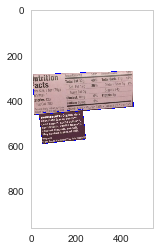

In [23]:
plt.imshow(regions[1])
plt.imshow(regions[0])

### 6. Vocabulary

In [166]:
import re
import pickle

In [169]:
def create_nutrition_vocabulary():
    '''
        1. Read the transcriptions, and turn then into a corpus
           where each line is a single valind transcription, i.e either
           structured nutrition information ---> 
                   {num_servings: 4, serving_size: 240 ml,
                   calories_per_serving: 15,calories_from_fat: n/a,total_fat: 0 g,
                   sat_fat: 0 g,trans_fat: 0 g,poly_fat: 0 g,mono_fat: 0 g,
                   cholesterol: 0 g,sodium: 830 mg, potassium: n/a, total_carb: 1 g,
                   dietary_fiber: 0 g, total_sugar: 1 g,added_sugar: 1 g,protein: 1 g},
           or structured ingridient info --> 
           [beef stock, salt, yeast, carrot, celery, onions,sugar,natural flavor]
        2. Create our target vocabulary, with all unique tokens in our corpus, this is
           what we'll sample from when transcribing.
        3. Stores the vocab and corpus as text files. The vocab will later be used to 
           create one hot vectors. The corpus will be used to create dense vectors
    '''
    def is_int(x):
        try: int(x); return True
        except: return False
    def create_target_sent(l):
        nutrition =  []
        for v in l:
            if isinstance(v, list):
                for it in v:
                    nutrition.append(it)
                continue
            nutrition.append(v)
        return nutrition
        
    id_regex = 'clip_id ?: ?([0-9]+)'
    nutr_regex = 'nutrition ?: ?({.*})'
    ingr_regex = 'ingredients ?: ?(\[.*\])'
    
    with open('./FullData/Transcriptions/all_transcriptions.txt', 'r') as transcriptions:
        all_transcriptions = transcriptions.read().replace('\n', "")
    product_transcr = re.split("\},{", all_transcriptions)
    vocab = set()
    corpus = open('./FullData/Transcriptions/corpus.txt', 'w+')
    i = 0
    for transcr in product_transcr:
        id_ = re.findall(id_regex, transcr)[0].strip()
        nutri = ' '.join(re.findall(nutr_regex, transcr)[0]
                         .replace(':', " : ")
                         .replace(',', '')
                         .split()).split()
        ingri = ' '.join(re.findall(ingr_regex, transcr)[0]
                         .replace(',', '')
                         .split()).split()
        nutrition = create_target_sent(
            [list(v) if is_int(v) else v for v in nutri]
        )
        ingridients = create_target_sent(
            [list(v) if is_int(v) else v for v in ingri]
        )
        corpus.write(' '.join(nutrition) + '\n')
        corpus.write(' '.join(ingridients) + '\n')
        vocab.update(nutrition); vocab.update(ingridients)
    corpus.close()
    with open('./FullData/Transcriptions/vocab.txt', 'wb+') as v:
        pickle.dump(list(vocab), v)
    print len(vocab)

In [170]:
create_nutrition_vocabulary()

639
